# Fashion Dataset

The dataset consists of various images of clothing accessories, footwears, personal care items etc. The task is to classify these images into their respective article type.

The data looks as follows, 



<img src="FashionData.png">

### Encrypted Training

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import time

import syft as sy  # import the Pysyft library

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import numpy as np

import matplotlib.pyplot as plt

import pickle

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/opt/conda/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [2]:
#Hyper-parameters for the training
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 64
        self.epochs = 3
        self.lr = 0.01
        self.seed = 1
        self.log_interval = 1 
        self.precision_fractional = 3

args = Arguments()

_ = torch.manual_seed(args.seed)


n_train_items = 640
n_test_items = 640

In [3]:
hook = sy.TorchHook(torch) 

# simulation functions
def connect_to_workers(n_workers):
    return [
        sy.VirtualWorker(hook, id=f"worker{i+1}")
        for i in range(n_workers)
    ]
def connect_to_crypto_provider():
    return sy.VirtualWorker(hook, id="crypto_provider")

workers = connect_to_workers(n_workers=2)
crypto_provider = connect_to_crypto_provider()

### Loading secret data

In [4]:
def get_encrypted_data_loaders(workers,precision,crypto_provider):
    
    def to_categorical(index_tensor):
       
        #print("Index_tensor = {}".format(index_tensor))
        cat_tensor = torch.zeros(*index_tensor.shape, 10) 
        cat_tensor = cat_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return cat_tensor
    
#         l=[]
#         for i in index_tensor:
#             l.append(np.eye(3, dtype='uint8')[i])
#         return torch.tensor(l)
        
    def secret_share(tensor):
        """
        Transform to fixed precision and secret share a tensor
        """
        return (
            tensor
            .fix_precision(precision_fractional=precision)
            .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
        )
    
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True, transform=transformation),
        batch_size=args.batch_size
    )
        
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, download=True, transform=transformation),
        batch_size=args.test_batch_size
    )
    
    encrypted_train_loader = [
        (secret_share(data), secret_share(to_categorical(target)))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    encrypted_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return encrypted_train_loader, encrypted_test_loader
    
    
encrypted_train_loader, encrypted_test_loader = get_encrypted_data_loaders(
    precision=args.precision_fractional,
    workers=workers,
    crypto_provider=crypto_provider
)

### Model specification

In [5]:
class Net(nn.Module):
    def __init__(self,layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, layers)
        self.fc2 = nn.Linear(layers, layers//2)
        self.fc3 = nn.Linear(layers//2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training and testing functions

In [6]:
#comparison params
loss_across_epoch = []
accuracy_across_epoch = []
time_across_epoch = []


In [7]:
def train(args, model, encrypted_train_loader, optimizer, epoch,verbose):
    model.train()
    for batch_idx, (data, target) in enumerate(encrypted_train_loader): 
        start_time = time.time()
        
        optimizer.zero_grad()
        
        output = model(data)
        
       
        batch_size = output.shape[0]
        loss = ((output - target)**2).sum().refresh()/batch_size
        
        loss.backward()
        loss = loss.get().float_precision()
        
        loss_across_epoch.append(loss.item())
        
        optimizer.step()
        t = time.time() - start_time
        time_across_epoch.append(t)
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                    epoch, batch_idx * args.batch_size, len(encrypted_train_loader) * args.batch_size,
                    100. * batch_idx / len(encrypted_train_loader), loss.item(), t))
            

In [8]:
def test(args, model, encrypted_test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in encrypted_test_loader:
            start_time = time.time()
            
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()
            #print(len(private_test_loader))

    correct = correct.get().float_precision()
    acc = 100. * correct.item() / (len(encrypted_test_loader) * args.test_batch_size)
    if verbose:
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct.item(), len(encrypted_test_loader)* args.test_batch_size,acc))
    return acc
    

### Start training

In [9]:
model = Net(128)
model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

optimizer = optim.SGD(model.parameters(), lr=args.lr)
optimizer = optimizer.fix_precision() 

for epoch in range(1, args.epochs + 1):
    train(args, model, encrypted_train_loader, optimizer, epoch,True)
    acc_t = test(args, model, encrypted_test_loader,True)
    accuracy_across_epoch.append(acc_t)

Train Epoch: 1 [0/640 (0%)]	Loss: 1.150000	Time: 3.641s
Train Epoch: 1 [64/640 (10%)]	Loss: 0.992000	Time: 3.601s
Train Epoch: 1 [128/640 (20%)]	Loss: 0.944000	Time: 3.551s
Train Epoch: 1 [192/640 (30%)]	Loss: 0.944000	Time: 3.655s
Train Epoch: 1 [256/640 (40%)]	Loss: 0.867000	Time: 3.663s
Train Epoch: 1 [320/640 (50%)]	Loss: 0.846000	Time: 3.648s
Train Epoch: 1 [384/640 (60%)]	Loss: 0.873000	Time: 3.677s
Train Epoch: 1 [448/640 (70%)]	Loss: 0.828000	Time: 3.658s
Train Epoch: 1 [512/640 (80%)]	Loss: 0.783000	Time: 3.676s
Train Epoch: 1 [576/640 (90%)]	Loss: 0.780000	Time: 3.717s

Test set: Accuracy: 241.0/640 (38%)

Train Epoch: 2 [0/640 (0%)]	Loss: 0.790000	Time: 3.662s
Train Epoch: 2 [64/640 (10%)]	Loss: 0.738000	Time: 3.618s
Train Epoch: 2 [128/640 (20%)]	Loss: 0.748000	Time: 3.668s
Train Epoch: 2 [192/640 (30%)]	Loss: 0.791000	Time: 3.688s
Train Epoch: 2 [256/640 (40%)]	Loss: 0.752000	Time: 3.678s
Train Epoch: 2 [320/640 (50%)]	Loss: 0.743000	Time: 3.656s
Train Epoch: 2 [384/640 (6

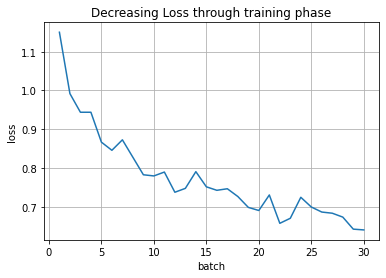

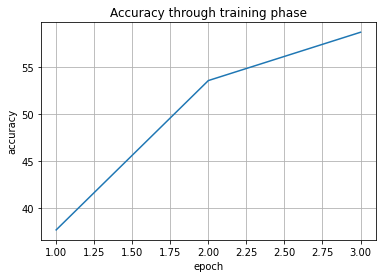

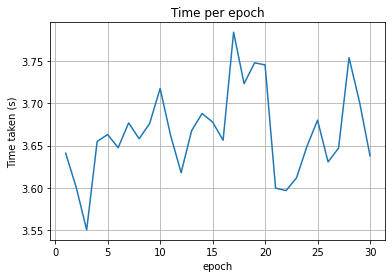

In [10]:
#print(loss_across_epoch)
cnt = np.arange(1, len(loss_across_epoch)+1, 1)

plt.plot( cnt,loss_across_epoch)

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Decreasing Loss through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(accuracy_across_epoch)+1, 1)

plt.plot( cnt,accuracy_across_epoch)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(time_across_epoch)+1, 1)

plt.plot( cnt,time_across_epoch)

plt.xlabel('epoch')
plt.ylabel('Time taken (s)')
plt.title('Time per epoch')
plt.grid(True)
plt.show()

In [ ]:
for n in nn_model_neurons:
    model = Net(n)
    model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optimizer.fix_precision() 

    for epoch in range(1, args.epochs + 1):
        train(args, model, encrypted_train_loader, optimizer, epoch,False)
        acc_t = test(args, model, encrypted_test_loader,False)
        
    print('\nTraining with {} neurons: Accuracy: {:.0f}%\n'.format(n,acc_t))
    accuracy_nn_model.append(acc_t)


Training with 16 neurons: Accuracy: 27%


Training with 24 neurons: Accuracy: 30%


Training with 32 neurons: Accuracy: 43%


Training with 48 neurons: Accuracy: 36%


Training with 64 neurons: Accuracy: 52%



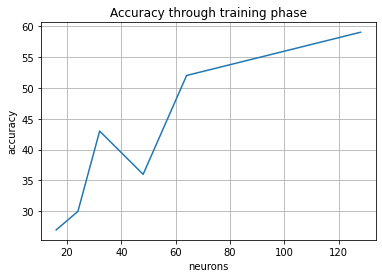

In [4]:
plt.plot( nn_model_neurons,accuracy_nn_model)

plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

##### We are getting over 50% accuracy using only a subset of 640 images on only 3 passes of encrypted training data. Training set and number of epochs were reduced in the interest of saving training time. We are interested to demonstrate the training on encrypted data and not focus on accuracy achieved

In [11]:
#Save metadata
with open('fashion-enc-time', 'wb') as fp:
    pickle.dump(time_across_epoch, fp)
    
with open('fashion-enc-acc', 'wb') as fp:
    pickle.dump(accuracy_across_epoch, fp)

In [5]:
with open('fashion-enc-comp', 'wb') as fp:
    pickle.dump(accuracy_nn_model, fp)